# Bayesian Fidget Spinners

Nat’s company manufactures fidget spinners. The company uses two factories, which we’ll call factory $0$ and factory $1$. Each fidget spinner from factory $k$ is defective with probability $q_k$ $(k \in {0, 1})$. Nat knows that factory $0$ produces fewer defective fidget spinners than factory $1$ (in other words, $q_0 < q_1$).

She receives $n$ boxes full of fidgest spinners, but the boxes aren't labeled (in other words she doesn't know which box is from which factory). For each box, she starts randomly pulling out fidget spinners until she finds a defective one, and records how many fidget spinners she pulled out (including the defective one). She calls this number $x_i$ for box $i$, for $i = 1, ..., n$.

She wants to estimate the following pieces of information:
- Which boxes came from factory $0$, and which came from factory $1$? She defines a binary random variable for each box $z_i$ with the factory label (i.e., $z_i = 0$ if box $i$ is from factory $0$, and $z_i = 1$ if box $i$ is from factory $1$).
- How reliable is each factory? In other words, what are $q_0$ and $q_1$?

We can set up the following probability model:

$$
\begin{align*}
z_i & \stackrel{}{\sim} \text{Bernoulli}(\pi) \\
q_k & \stackrel{}{\sim} \text{Beta}(\alpha_k, \beta_k) \\
x_i|z_i, q_0, q_1 & \stackrel{}{\sim} \text{Geometric}(q_{z_i}) \\
\end{align*}
$$

With the following graphical model for $n=2$ (only 2 boxes):

<p align="center" width="100%">
    <img width="33%" src="pmodel.png"> 
</p>

Note that $x_1$ and $x_2$ are shaded because they're the only things we are allowed to observe. And since we don't know which factory each box are coming from, both $q_0$ and $q_1$ (the probability of making a defective fidget spinner from factory $0$ and $1$, respectively) point to each of the boxes.

Suppose we believe that factory $1$ makes less boxes than factory $0$. More specifically, suppose that 30% of all boxes Nat receives come from factory $1$.

Additionally, suppose that on average 1 out of 6 spinners from factory $0$ are defects, while 5 out of 6 spinners are defects from factory $1$. Nat is not confident in these estimates.

Putting that together, we fix the hyperparameters as follows:

$$
\pi = 0.3 \quad q_0 \stackrel{}{\sim} \text{Beta}(1, 5) \quad q_1 \stackrel{}{\sim} \text{Beta}(5, 1)
$$

Suppose we get the following data `y_obs` below:

In [1]:
import numpy as np
np.random.seed(5)

N = 100
pi = 0.3

q0 = 0.05
q1 = 0.18

n1 = int(N * pi)
n0 = N - n1

y_obs = np.zeros(N)
y_obs[:n0] = np.random.geometric(q0, size=n0)
y_obs[n0:] = np.random.geometric(q1, size=n1)

print(y_obs)

[ 5. 40.  5. 49. 14. 19. 29. 15.  7.  5.  2. 27. 12.  4. 42.  7. 11.  7.
 20. 17. 18.  7.  7.  6.  8.  4.  4. 65. 63.  5.  1.  5. 24. 30.  1. 17.
  1. 15. 20. 83.  6. 32. 40. 50.  1. 13. 78. 10. 33. 16. 29. 13.  1.  2.
  3.  6. 66. 20. 34. 17. 20. 33. 51. 48. 34.  2.  9.  1. 16. 32.  1.  2.
  3.  2.  8.  3.  6.  4.  5. 15. 15.  1. 10.  3.  1.  3.  4. 17.  3.  1.
 10.  1.  4. 10.  4.  3.  9.  1.  5.  3.]


So from this sample, Nat's first box has 5 defects, second box has 40 defects, and so forth. From this sample, our random process involves drawing 100 random boxes. As a reminder, we would like to estimate which boxes come from which factory and their respective defect rates, based on the data `y_obs` above using the technique of Markov Chain Monte Carlo.

In [2]:
import pymc as pm

N = len(y_obs)
alphas = (1, 5)
betas = (5, 1)
pi = .3

with pm.Model() as model:
    z = pm.Bernoulli("z", p=pi, shape=N)
    q = pm.Beta("q", alpha=alphas, beta=betas, shape=2) # factory0, factory1
    X = pm.Geometric('X', observed=y_obs, p=q[z]) # fancy indexing, e.g. p=q0 when z=0
    trace = pm.sample(1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [z]
>NUTS: [q]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
C:\Users\Peter\.conda\envs\mcmc\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


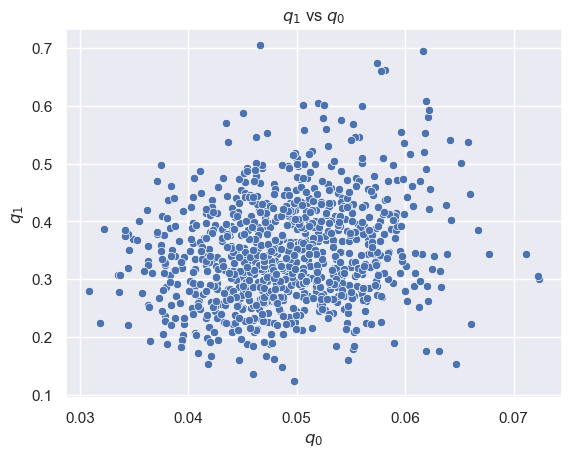

In [3]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sampled_posterior_q = np.array(trace.get('posterior')['q'][0, :, :]) # defect rates sampled from the posterior
q0_samples = sampled_posterior_q[:, 0]
q1_samples = sampled_posterior_q[:, 1]
sampled_posterior_z = np.array(trace.get('posterior')['z'][0, :, :])

sns.set()
ax = sns.scatterplot(x=q0_samples, y=q1_samples)
ax.set_xlabel("$q_0$");
ax.set_ylabel("$q_1$");
ax.set_title("$q_1$ vs $q_0$");

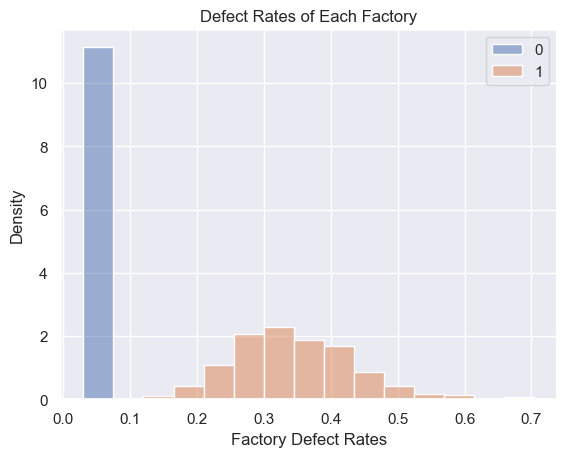

In [4]:
ax = sns.histplot(sampled_posterior_q, stat="density");
ax.set_xlabel("Factory Defect Rates");

ax.set_title("Defect Rates of Each Factory");

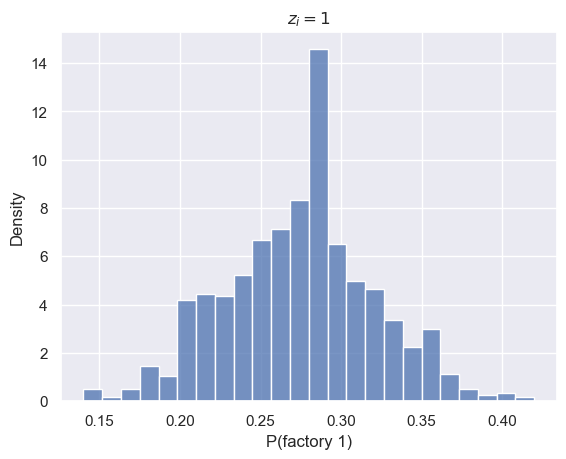

In [5]:
ax = sns.histplot(np.sum(sampled_posterior_z, axis=1) / N, stat="density");
ax.set_xlabel("P(factory 1)");
ax.set_title("$z_i = 1$");

In [6]:
from IPython.display import display, Markdown
import scipy

med_estimate_q0 = np.median(q0_samples)
med_estimate_q0 = round(med_estimate_q0, 4)

med_estimate_q1 = np.median(q1_samples)
med_estimate_q1 = round(med_estimate_q1, 4)

# for each of the 100 draws, see whether there were more factory 0 boxes than factory 1 boxes
num_boxes_f1 = np.sum(sampled_posterior_z, axis=1) # number of boxes that factory 1 produces for each sample
num_boxes_f0 = np.ones(len(num_boxes_f1))*N - num_boxes_f1
more_from_f0_prob = np.mean(num_boxes_f0 > num_boxes_f1)

display(Markdown(
   rf"""
$q_0$

$\quad$ True: ${q0}$

$\quad$ Estimate: ${med_estimate_q0}$

---
$q_1$

$\quad$ True: ${q1}$

$\quad$ Estimate: ${med_estimate_q1}$

---
$P($count from factory 0 > count from factory 1$)$

$\quad$ True: ${scipy.stats.binom.cdf(50, 100, .3)}$

$\quad$ Estimated: ${more_from_f0_prob}$
"""))


$q_0$

$\quad$ True: $0.05$

$\quad$ Estimate: $0.0488$

---
$q_1$

$\quad$ True: $0.18$

$\quad$ Estimate: $0.3384$

---
$P($count from factory 0 > count from factory 1$)$

$\quad$ True: $0.9999909653138043$

$\quad$ Estimated: $1.0$


Under the sampled posterior, the probability that factory 0 produces more boxes than factory 1 is $1.0$, which is extremely close the theoretical value, given Nat's prior.

Additionally, based on samples from the posterior, a median estimate of factory 0's defect rate is $0.0486$, which is close to the true value. On the other hand, the posterior median estimate of factory 1's defect rate of $0.18$ is fairly far off from the true value.

# Notes
- PyMC has some odd dependencies on different versions. [This ticket](https://github.com/pymc-devs/pymc/issues/5322) resolved the issues I had with importing, ultimately leading me to updating [this package](https://anaconda.org/conda-forge/aesara).